1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import seaborn as sns
from scipy import stats
%matplotlib inline

(array([ 0.,  0.,  4., 10., 19., 38., 36., 39., 24., 19.,  8.,  1.,  2.,
        0.,  0.]), array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,
        2. ,  2.5,  3. ,  3.5,  4. ]), <a list of 15 Patch objects>)


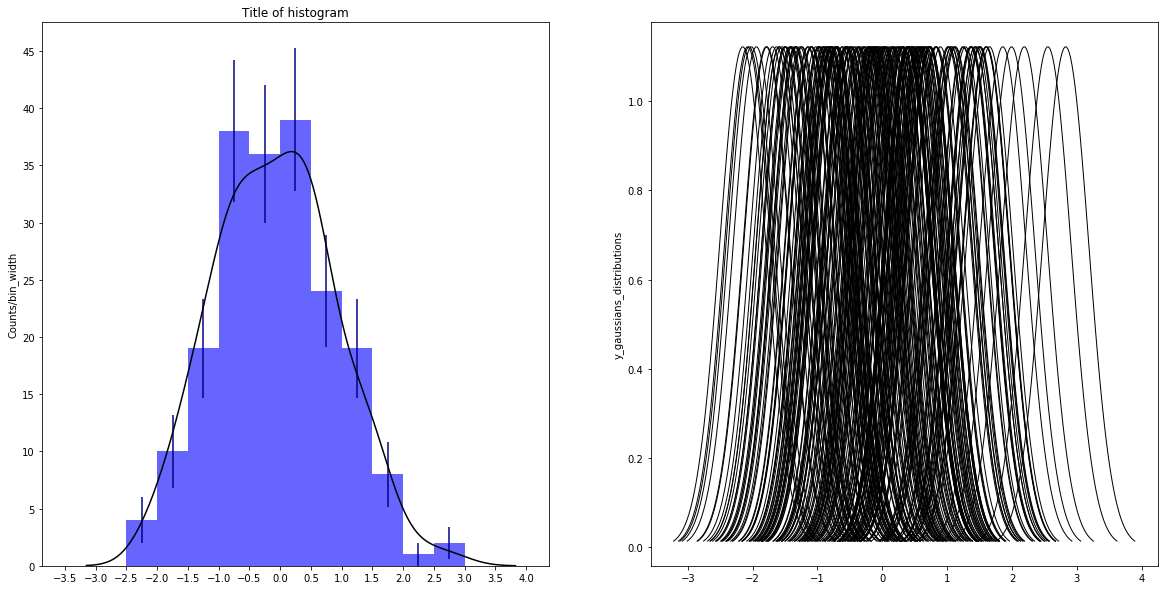

In [6]:
mean_, std_ = 0., 1
N = 200
x = np.random.normal(mean_, std_, N)

fig, (ax1, ax2) = plt.subplots ( nrows = 1, ncols = 2  , figsize = (20, 10))

width = int(std_)/2.

#ax.hist(x, bins=np.arange( -4*std_+mean_, 4*std_+mean_+1, int(round(std_/(N/100.)+1))), label='x')
y = (ax1.hist(x, bins=np.arange( -3.5*std_+mean_, 3.5*std_+mean_+1, width) , label='x'))
#ax1.set_ylabel(('Counts/'+str(std_/(N/100.))))
#ax1.set_ylabel('Counts/bin_width with bin_width = '+str(std_/(N/100.)))
ax1.set_ylabel('Counts/bin_width')
ax1.set_title('Title of histogram')
#ax1.xaxis.set_major_locator(MultipleLocator(int(round(std_/(N/1.)+1))))
ax1.xaxis.set_major_locator(MultipleLocator(width))
ax1.yaxis.set_major_locator(MultipleLocator(int(5*std_)))    # FWHM = 2.355*std

print(y)

# Faccio media dei bordi dei bin per avere il punto centrale
x_coord = 0.5*(y[1][1:] + y[1][:-1])

# Faccio le radici per avere l'errore sui bin
bin_stds = np.sqrt(y[0])

ax1.bar(x_coord, y[0], width=width, yerr = bin_stds, ecolor = "#000088", color="#6666ff")

std_x_ = 1.06*x.std()*(x.size**(-0.2))

ax2.set_ylabel('y_gaussians_distributions')

# Trying color modulation
col_min = 0            # 0x000000 (r = 00,       g = 00,       b = 00) = black
col_max = 0xffff00     # 0xffff00 (r = ff (max), g = ff (max), b = 00) = yellow

for val in x:
    interv = np.linspace(val-3*std_x_, val+3*std_x_, 100)
#    color_ = 
    ax2.plot(interv, stats.norm.pdf(interv, loc=val , scale=std_x_), 'k', lw = 1)



x_to_sums = np.linspace( -1+x.min(), x.max()+1, N )

#for x_val in x_to_sums:
#    ax1.plot(x_val, np.sum([x_gaussians(x, loc=x_val , scale=std_x_)])*width, 'ko')


y_KDE = x_to_sums.copy()

for cont in range(len(y_KDE)):
    y_KDE[cont] = np.sum(stats.norm.pdf(x, loc=x_to_sums[cont] , scale=std_x_))*width

ax1.plot(x_to_sums, y_KDE, 'k-')

# RINORMALIZZARE RISPETTO AL BINNING

/home/tommaso/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


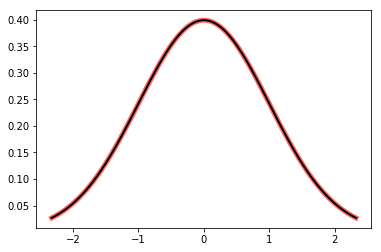

In [26]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(stats.norm.ppf(0.01), stats.norm.ppf(0.99), 100)
ax.plot(x, stats.norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

rv = stats.norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

fig.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2018-11-27 14:58:40--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2018-11-27 14:58:40--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc42a30e0d6a784bd3cf9f943e6c.dl.dropboxusercontent.com/cd/0/inline/AWbLF3axlib7w534zWcV1YN7NkouPS1N0Q3ERnuE9JnUrQVFQYx9oF-uxq8xOUSrRXePboQ1Q1iVhB1QZ-Q_GKFqkbERCeTek0pQyfUkKLeWWKLXCb4d5Ukqwm4bMQjc87FQrGtSlh1tvdkYH-UMFYMblgrgigVS8F4X-jrh_s0I_d9B4wMCXO_NPwPHpvziZRE/file [following]
--2018-11-27 14:58:41--  https://uc42a30e0d6a784bd3cf9f943e6c.dl.dropboxusercontent.com/cd/

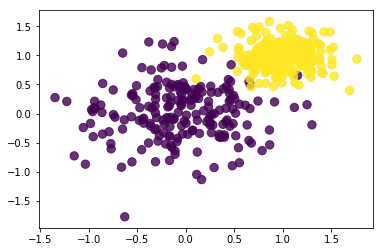

In [1]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot